In [1]:
from decouple import config
import pandas as pd
import pandas_ta as ta
from deap import gp

from Ionomy import IonPanda, BitTA
from GPrules import DemiChad

In [2]:
# MARKET = 'usd-btc'
# CURRENCY = 'btc'
# BASE = 'usd'
# TIME = 'hour'
# LIMIT = 20_000

In [3]:
# bta = BitTA(config('TREX_KEY'), config('TREX_SECRET'))
# ionpd = IonPanda(config('IONOMY_KEY'), config('IONOMY_SECRET'))
# bta.update(CURRENCY, BASE, TIME, LIMIT)
# df = bta.df
# df.to_csv('./btc-usd.csv', index=False)

In [4]:
df = pd.read_csv('./btc-usd.csv')

In [5]:
df = df[df['volume'] != 0]

In [6]:
%%capture
demichad = DemiChad(df[-12500:])

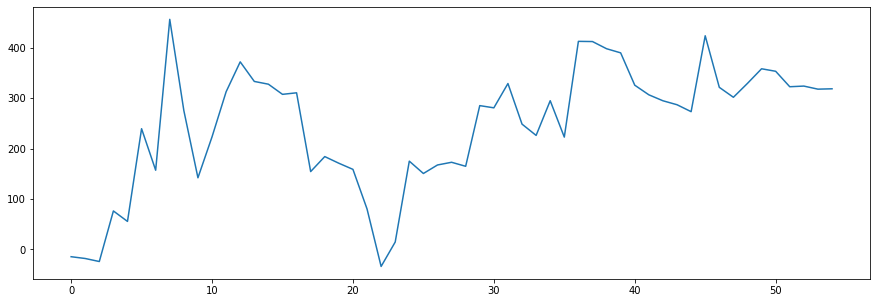

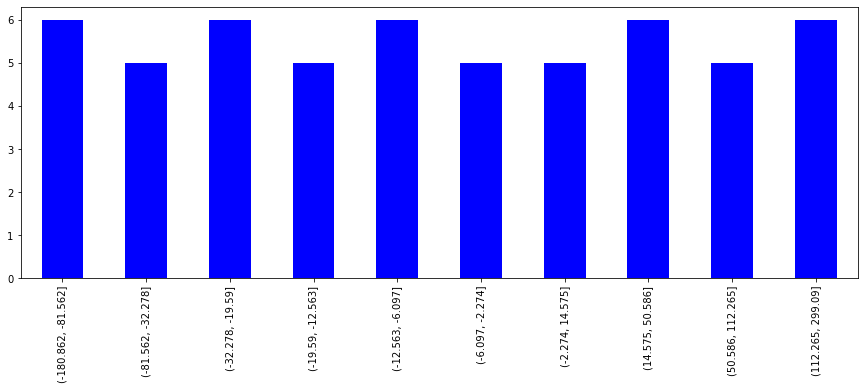

,Size,Execution Time,avg_ROI,Total Profit,Max Profit,Min Profit,Mean Profit,Root Number Trades,Standard Deviation,System Quality Number,Number Trades,Number Longs,Number Shorts,Number Positive,Sum Positive,Number Negative,Sum Negative,Number Not Closed,closed_ratio,mean_entry_time_diff,trade_duration,trade_time_coeff
0,26,0 mins 8 secs,0.01202,318.530656,299.089768,-180.861436,5.791466,12.238457,85.427628,0.829692,55,27,28,21,1712.641138,34,-1394.110482,1,0.982143,216.055556,215.672727,1.001775


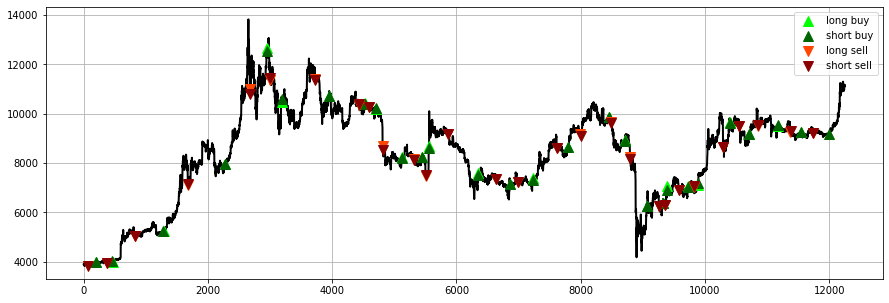

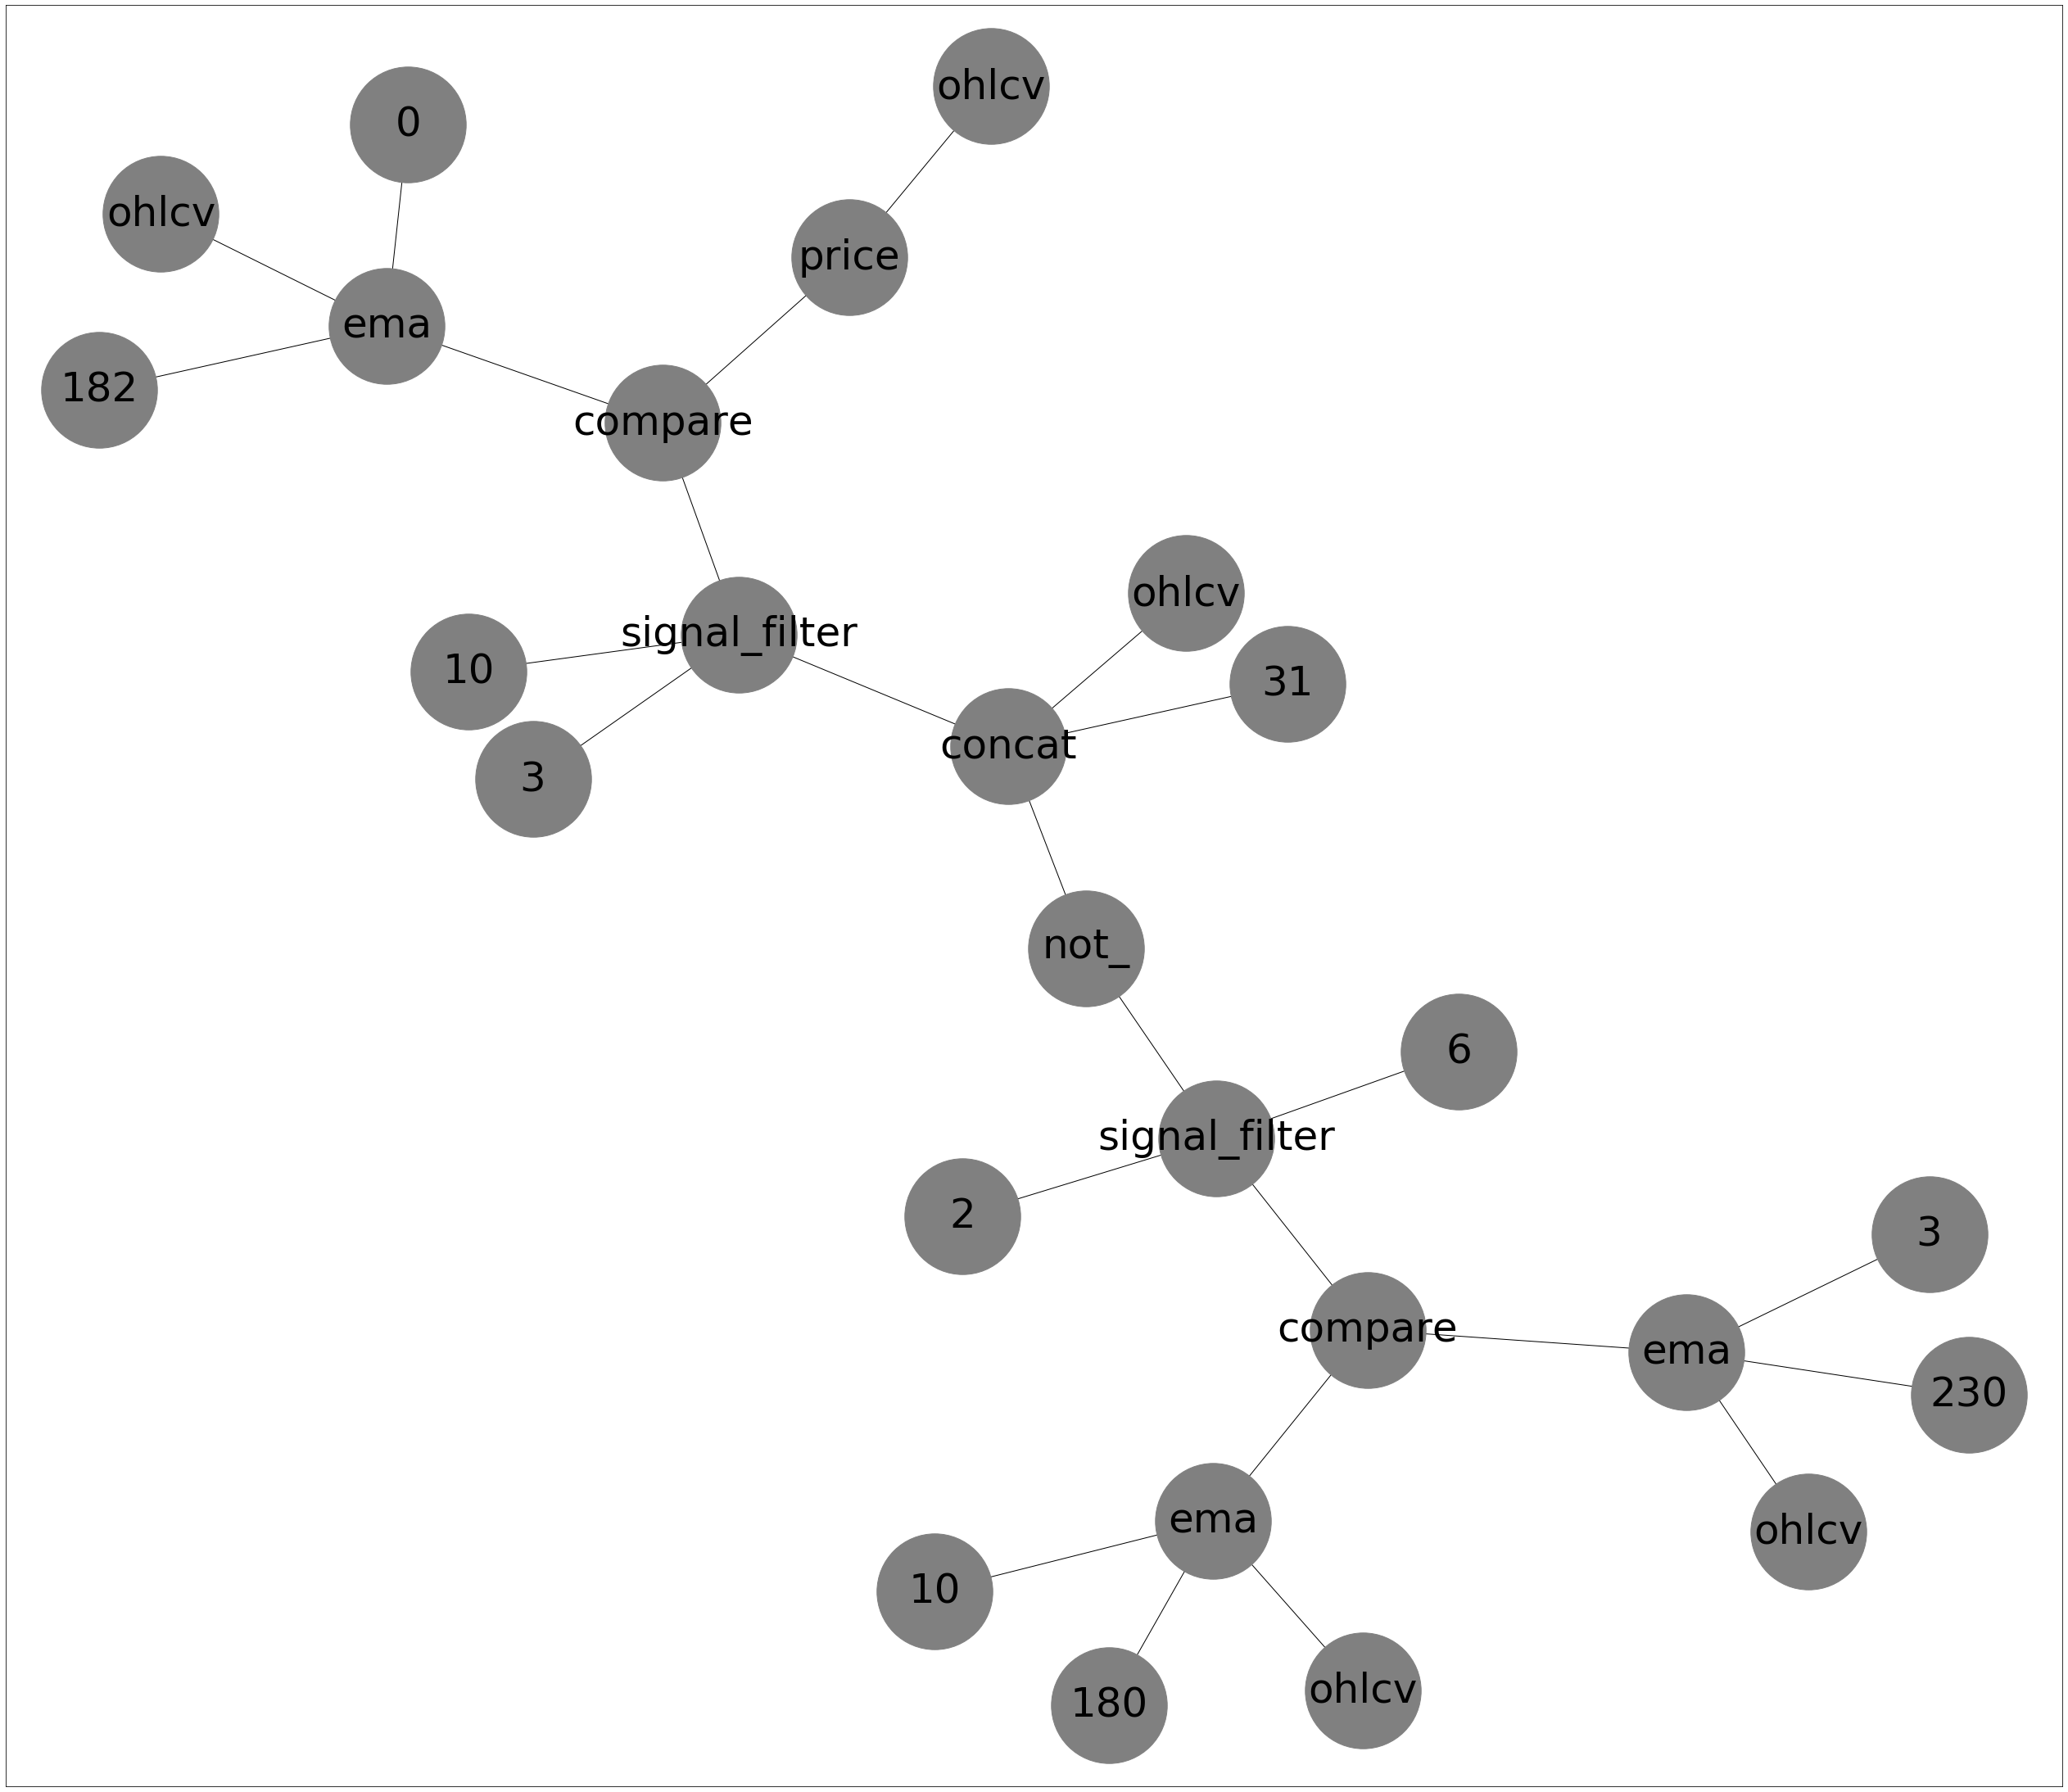

       entry     exit   type entry_time exit_time    profit closed
0    384.848  397.645  short         75       195   -14.362   True
1    398.658  396.717   long        196       381  -3.53175   True
2    396.901  401.299  short        382       462   -5.9944   True
3    400.500  502.536   long        463       820    100.23   True
4    505.009  523.682  short        821      1283  -20.7304   True
5    525.848  712.101   long       1284      1676   183.777   True
6    716.382  795.645  short       1677      2274  -82.2871   True
7    797.116     1100   long       2275      2674    299.09   True
8   1080.265  1256.45  short       2675      2952  -180.861   True
9   1267.000  1138.58   long       2953      2996  -133.229   True
10  1145.208  1059.64  short       2997      3187   81.1613   True
11  1048.000  1141.75   long       3188      3725   89.3705   True
12  1137.432   1073.7  short       3726      3942   59.3117   True
13  1070.927  1036.31   long       3943      4429  -38.8295   

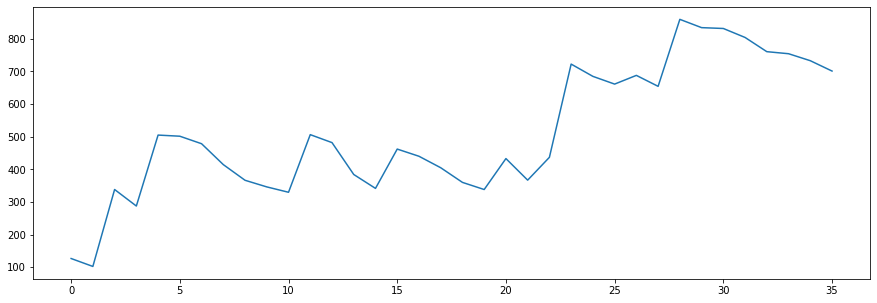

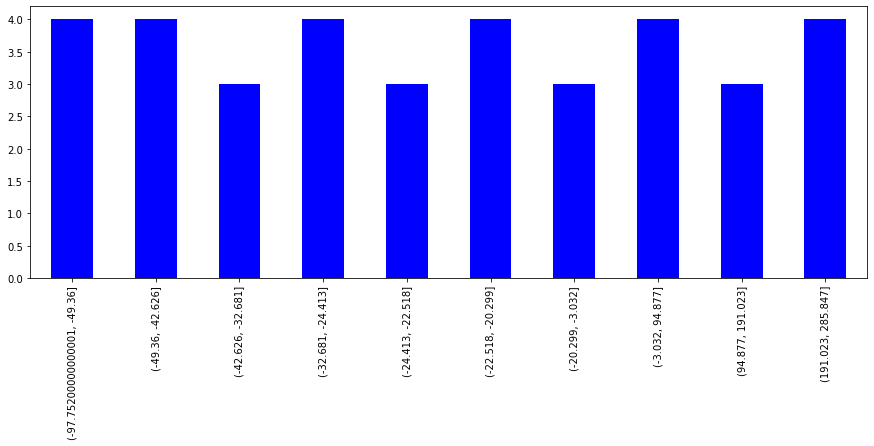

,Size,Execution Time,avg_ROI,Total Profit,Max Profit,Min Profit,Mean Profit,Root Number Trades,Standard Deviation,System Quality Number,Number Trades,Number Longs,Number Shorts,Number Positive,Sum Positive,Number Negative,Sum Negative,Number Not Closed,closed_ratio,mean_entry_time_diff,trade_duration,trade_time_coeff
0,26,0 mins 8 secs,0.012020,318.530656,299.089768,-180.861436,5.791466,12.238457,85.427628,0.829692,55,27,28,21,1712.641138,34,-1394.110482,1,0.982143,216.055556,215.672727,1.001775
1,26,0 mins 8 secs,0.031625,701.246134,285.846854,-97.751400,19.479059,9.390507,96.928652,1.887143,36,18,18,10,1559.952234,26,-858.706100,1,0.972973,340.142857,333.277778,1.020599


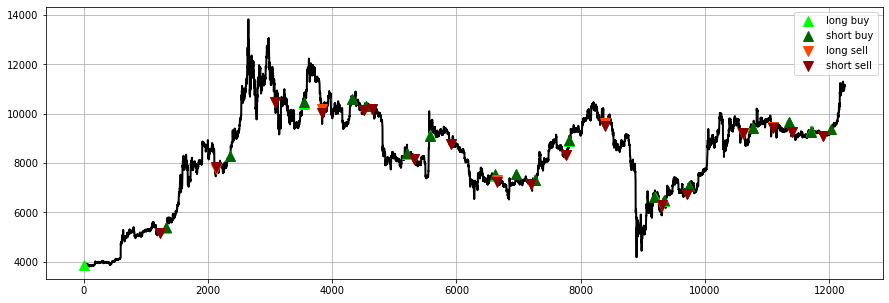

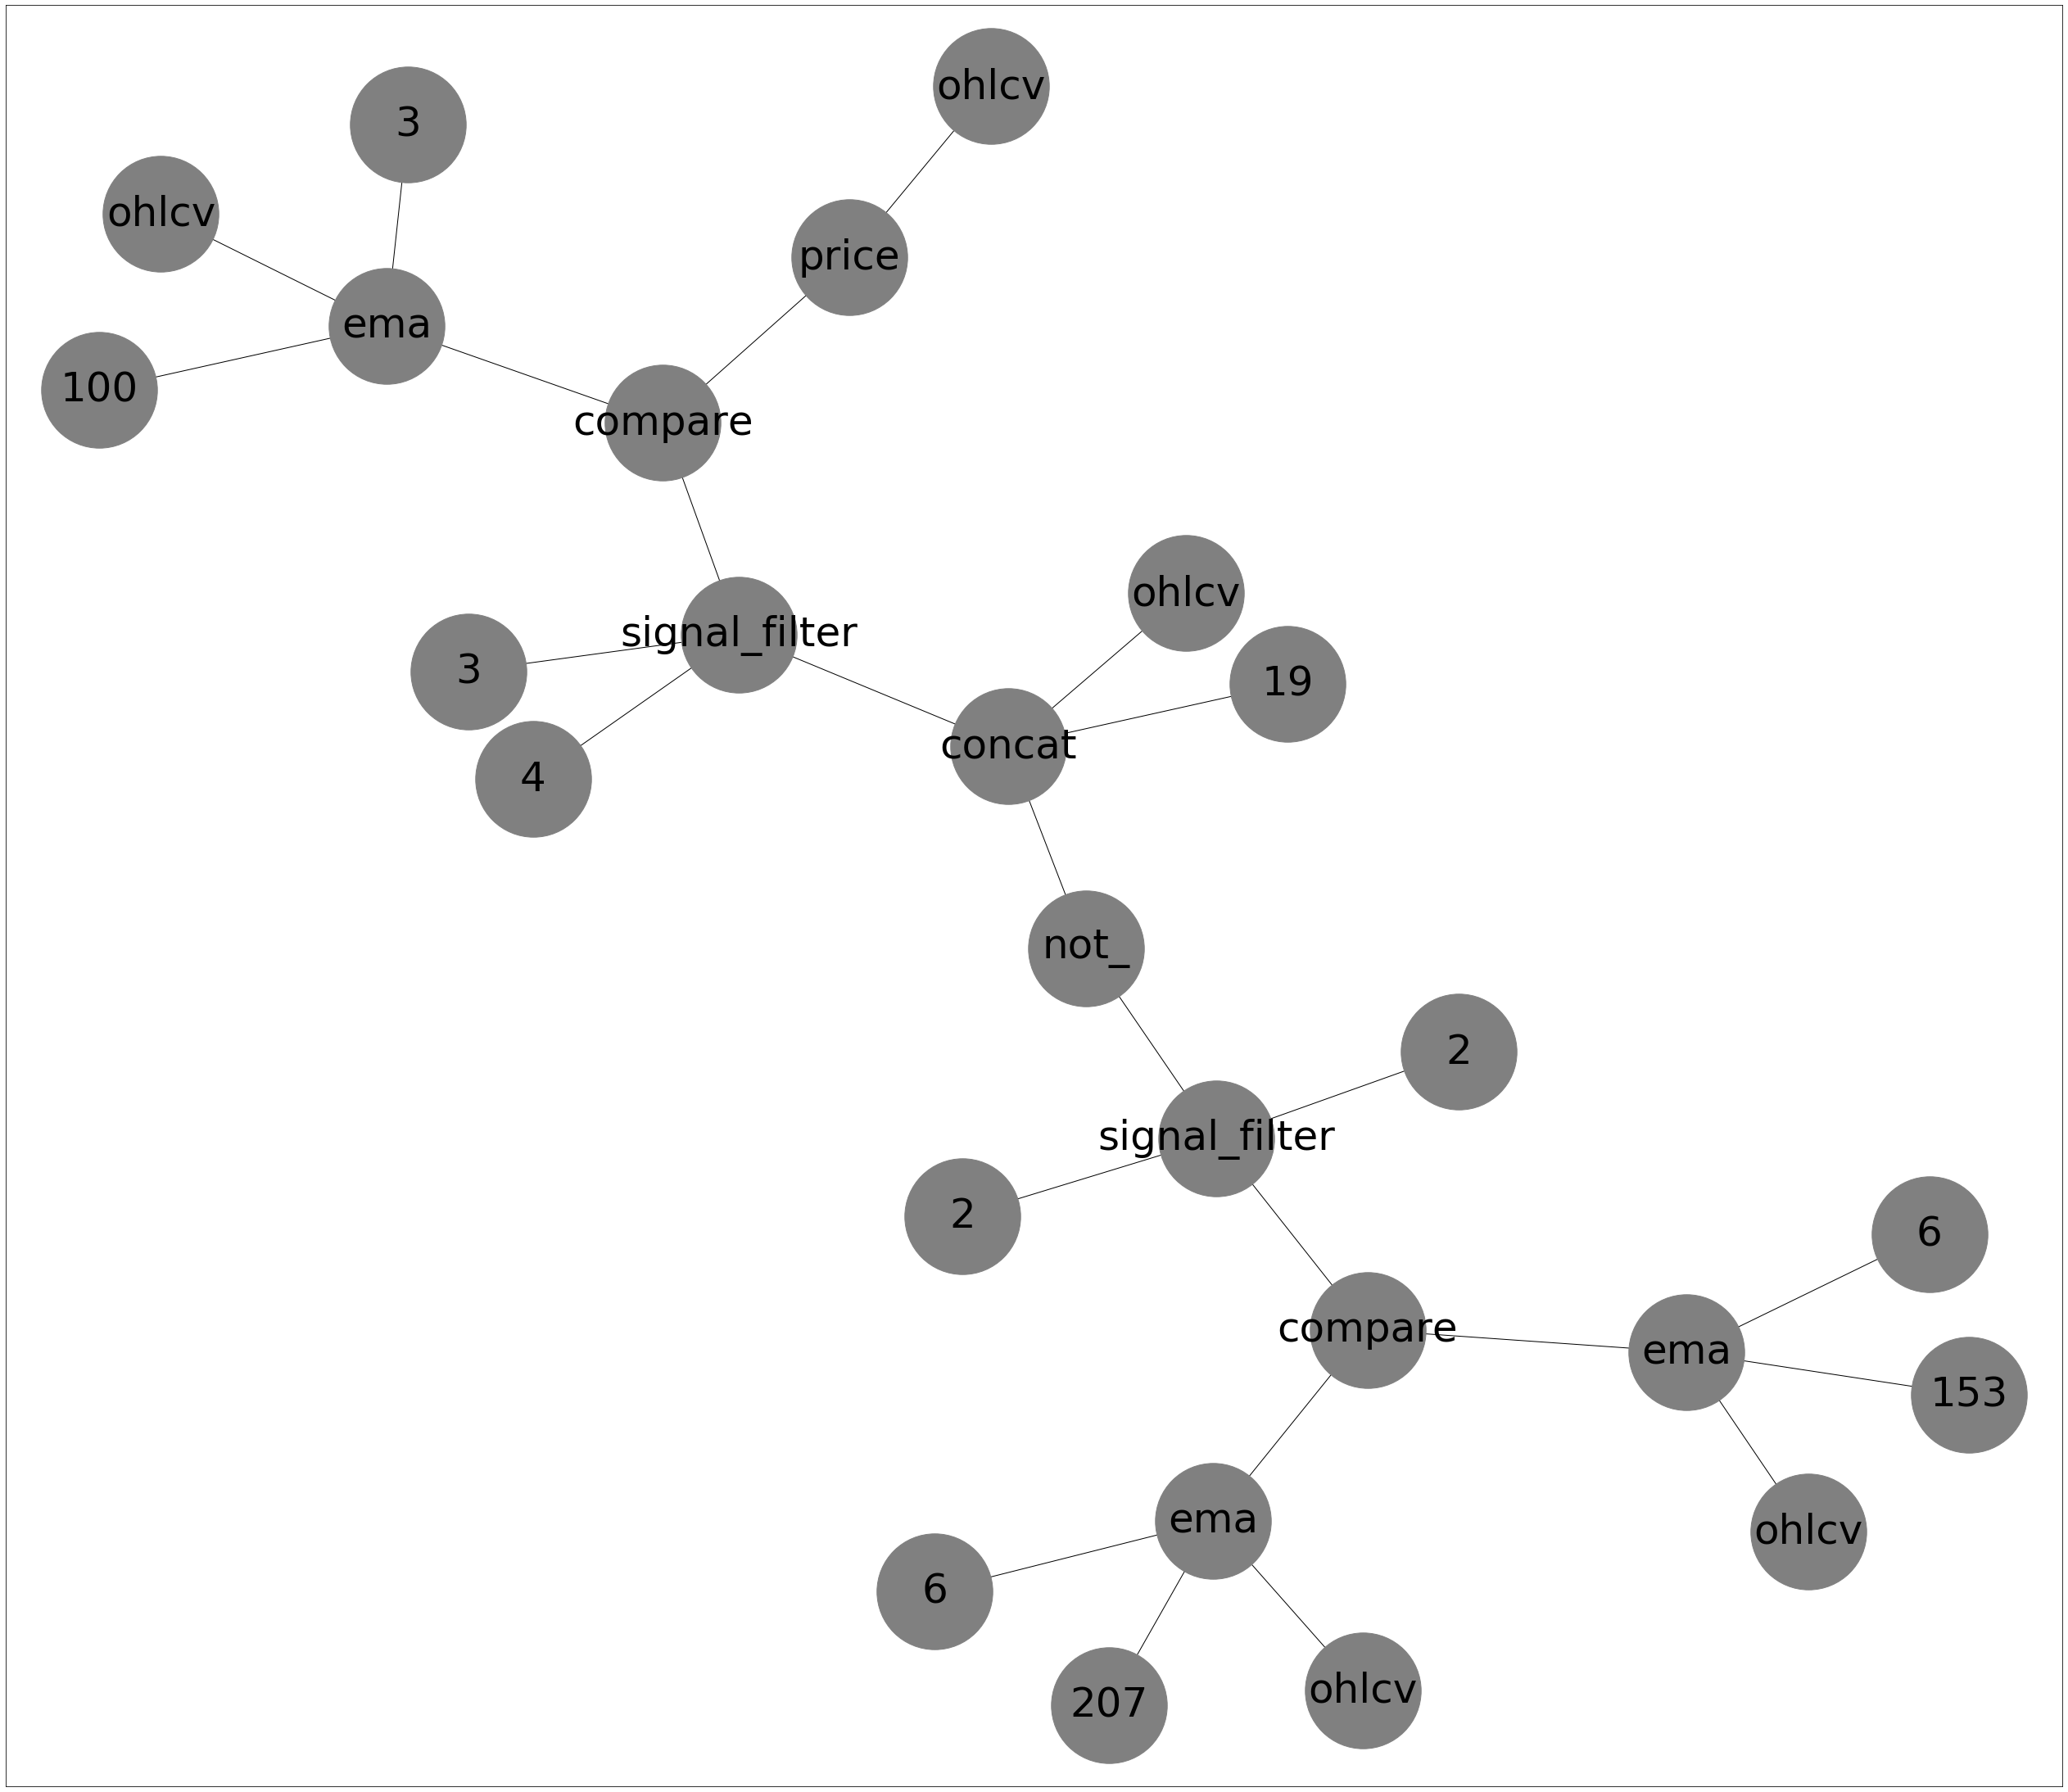

       entry     exit   type entry_time exit_time   profit closed
0    388.711  517.021   long          0      1221  126.499   True
1    518.177  540.378  short       1222      1326 -24.3181   True
2    537.669  776.209   long       1327      2133  235.912   True
3    782.900   830.33  short       2134      2354 -50.6565   True
4    827.700  1048.98   long       2355      3082  217.526   True
5   1048.356  1047.65  short       3083      3539 -3.48401   True
6   1039.941  1021.05   long       3540      3830  -23.017   True
7   1002.100     1062  short       3831      4316 -64.0282   True
8   1059.648  1015.74   long       4317      4504 -48.0628   True
9   1015.048  1031.25  short       4505      4550 -20.2986   True
10  1031.002  1018.64   long       4551      4638 -16.4613   True
11  1020.900    840.5  short       4639      5207  176.677   True
12   837.868  816.764   long       5208      5321 -24.4133   True
13   815.700      910  short       5322      5573 -97.7514   True
14   915.9

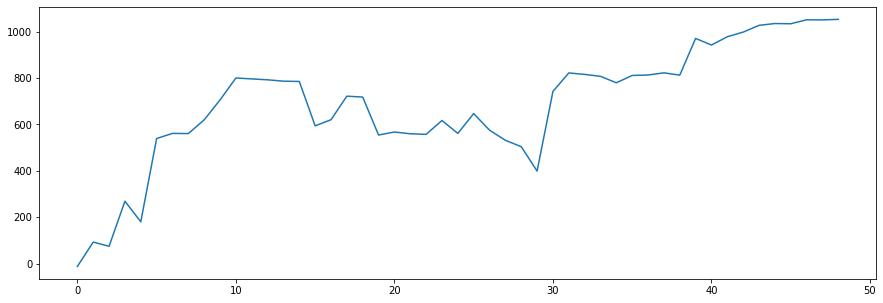

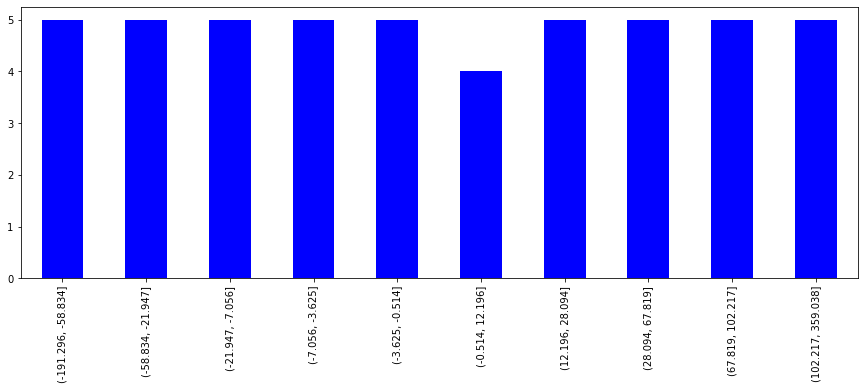

,Size,Execution Time,avg_ROI,Total Profit,Max Profit,Min Profit,Mean Profit,Root Number Trades,Standard Deviation,System Quality Number,Number Trades,Number Longs,Number Shorts,Number Positive,Sum Positive,Number Negative,Sum Negative,Number Not Closed,closed_ratio,mean_entry_time_diff,trade_duration,trade_time_coeff
0,26,0 mins 8 secs,0.012020,318.530656,299.089768,-180.861436,5.791466,12.238457,85.427628,0.829692,55,27,28,21,1712.641138,34,-1394.110482,1,0.982143,216.055556,215.672727,1.001775
1,26,0 mins 8 secs,0.031625,701.246134,285.846854,-97.751400,19.479059,9.390507,96.928652,1.887143,36,18,18,10,1559.952234,26,-858.706100,1,0.972973,340.142857,333.277778,1.020599
2,26,0 mins 8 secs,0.032343,1052.426882,359.037974,-191.294646,21.478100,11.386036,96.408483,2.536607,49,24,25,24,1942.343180,25,-889.916298,1,0.980000,243.145833,241.469388,1.006943


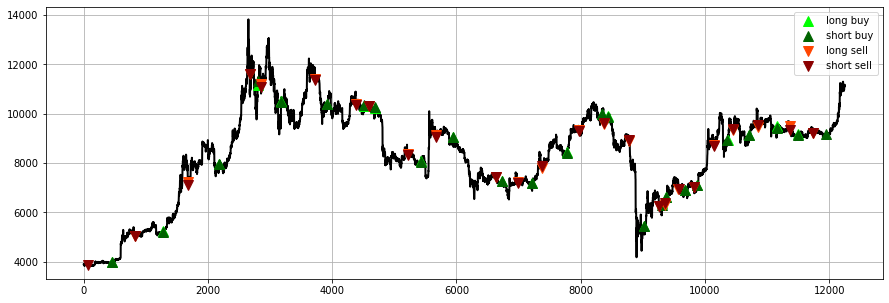

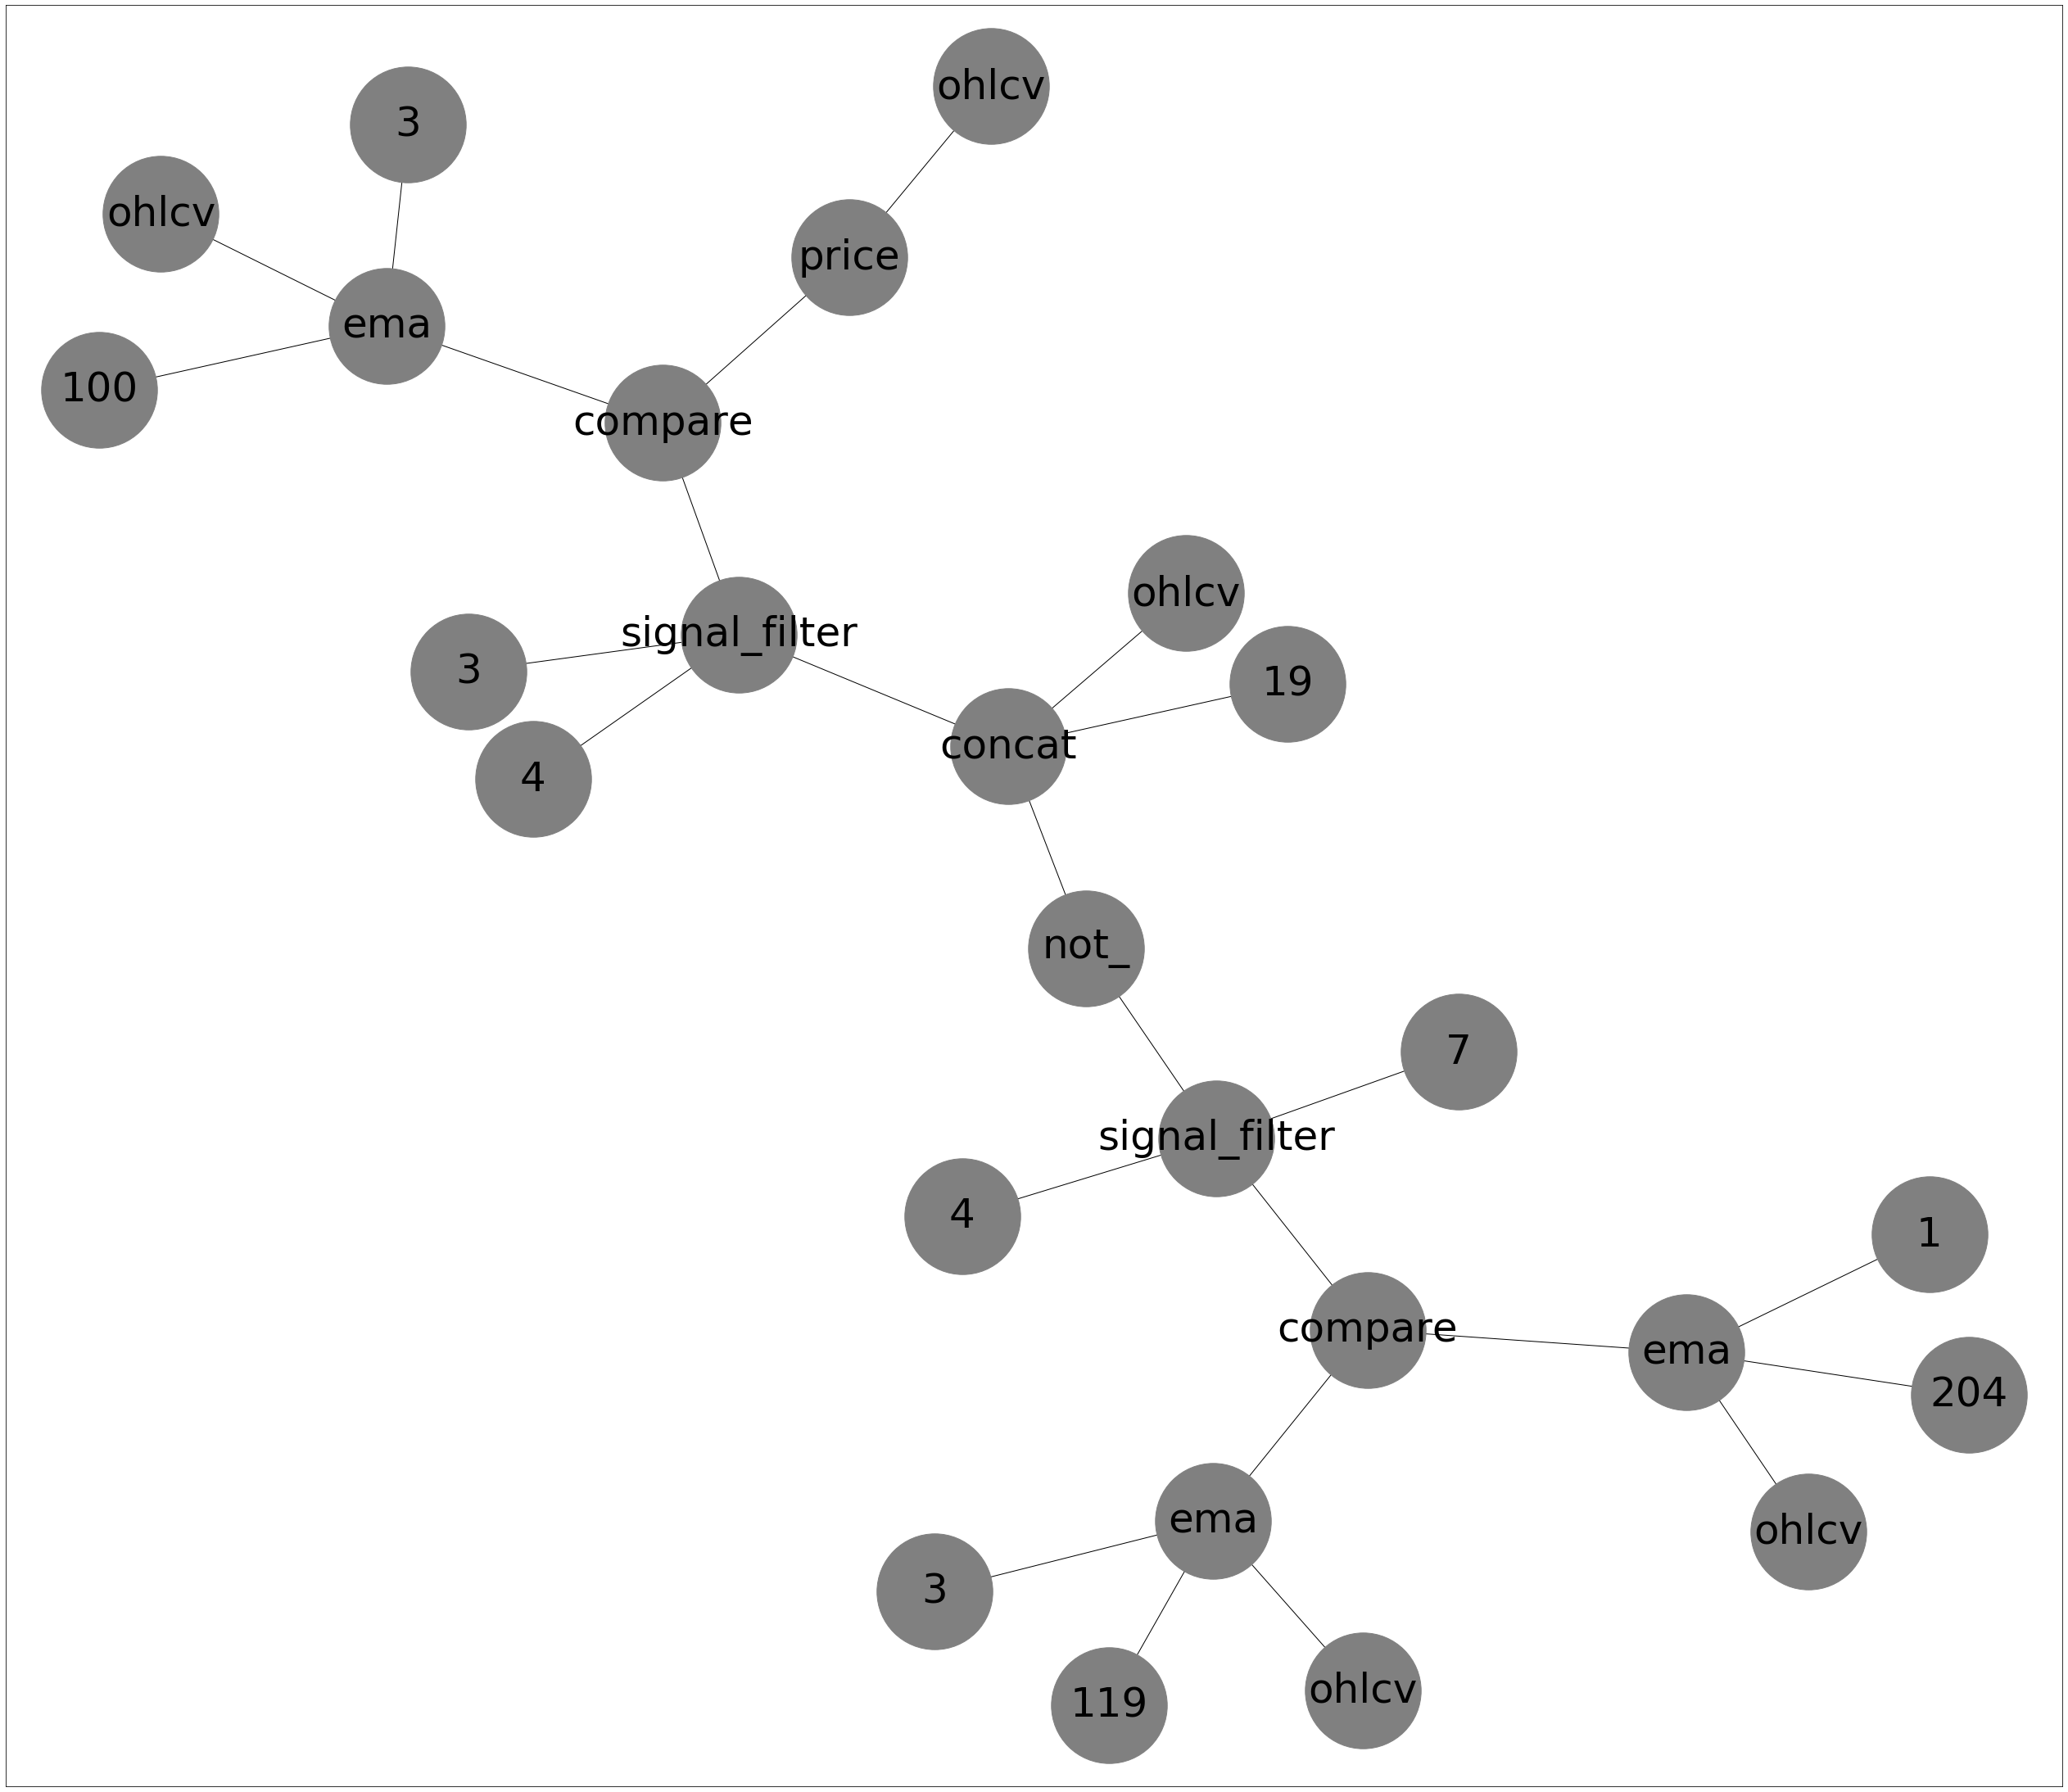

       entry     exit   type entry_time exit_time    profit closed
0    386.439  397.395  short         69       449  -12.5237   True
1    397.749  504.602   long        450       818   105.048   True
2    505.301  521.461  short        819      1275  -18.2135   True
3    525.503  722.321   long       1276      1675   194.322   True
4    712.101    797.9  short       1676      2183   -88.819   True
5    796.781  1159.73   long       2184      2669   359.038   True
6   1160.525  1133.91  short       2671      2801   22.0291   True
7   1116.788  1120.54   long       2802      2849 -0.719662   True
8   1110.256   1046.8  short       2850      3175   59.1419   True
9   1051.500  1141.75   long       3176      3725   85.8635   True
10  1137.432   1038.5  short       3726      3915   94.5801   True
11  1038.705  1038.86   long       3916      4380  -4.00013   True
12  1035.375  1035.12  short       4381      4518    -3.891   True
13  1031.954   1030.2   long       4519      4599  -5.87831   

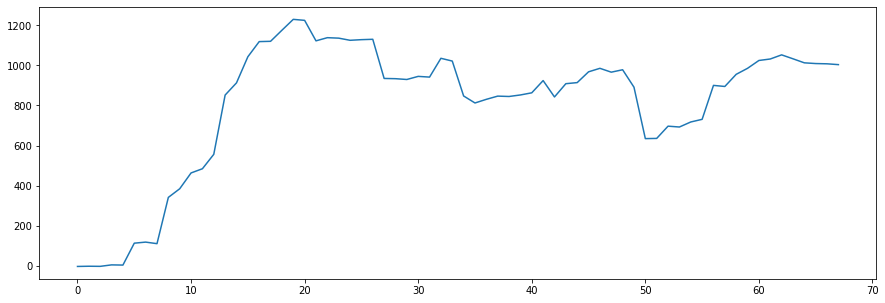

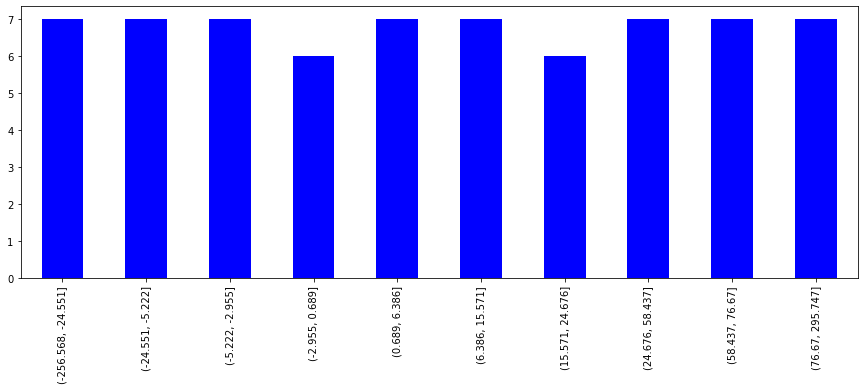

,Size,Execution Time,avg_ROI,Total Profit,Max Profit,Min Profit,Mean Profit,Root Number Trades,Standard Deviation,System Quality Number,Number Trades,Number Longs,Number Shorts,Number Positive,Sum Positive,Number Negative,Sum Negative,Number Not Closed,closed_ratio,mean_entry_time_diff,trade_duration,trade_time_coeff
0,26,0 mins 8 secs,0.012020,318.530656,299.089768,-180.861436,5.791466,12.238457,85.427628,0.829692,55,27,28,21,1712.641138,34,-1394.110482,1,0.982143,216.055556,215.672727,1.001775
1,26,0 mins 8 secs,0.031625,701.246134,285.846854,-97.751400,19.479059,9.390507,96.928652,1.887143,36,18,18,10,1559.952234,26,-858.706100,1,0.972973,340.142857,333.277778,1.020599
2,26,0 mins 8 secs,0.032343,1052.426882,359.037974,-191.294646,21.478100,11.386036,96.408483,2.536607,49,24,25,24,1942.343180,25,-889.916298,1,0.980000,243.145833,241.469388,1.006943
3,20,0 mins 6 secs,0.024238,1003.890328,295.746960,-256.566616,14.763093,13.973914,77.970759,2.645841,68,47,21,41,2068.144900,27,-1064.254572,1,0.985507,176.552239,166.558824,1.059999


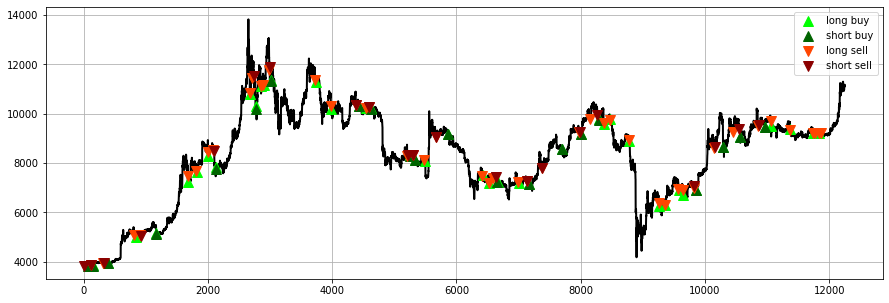

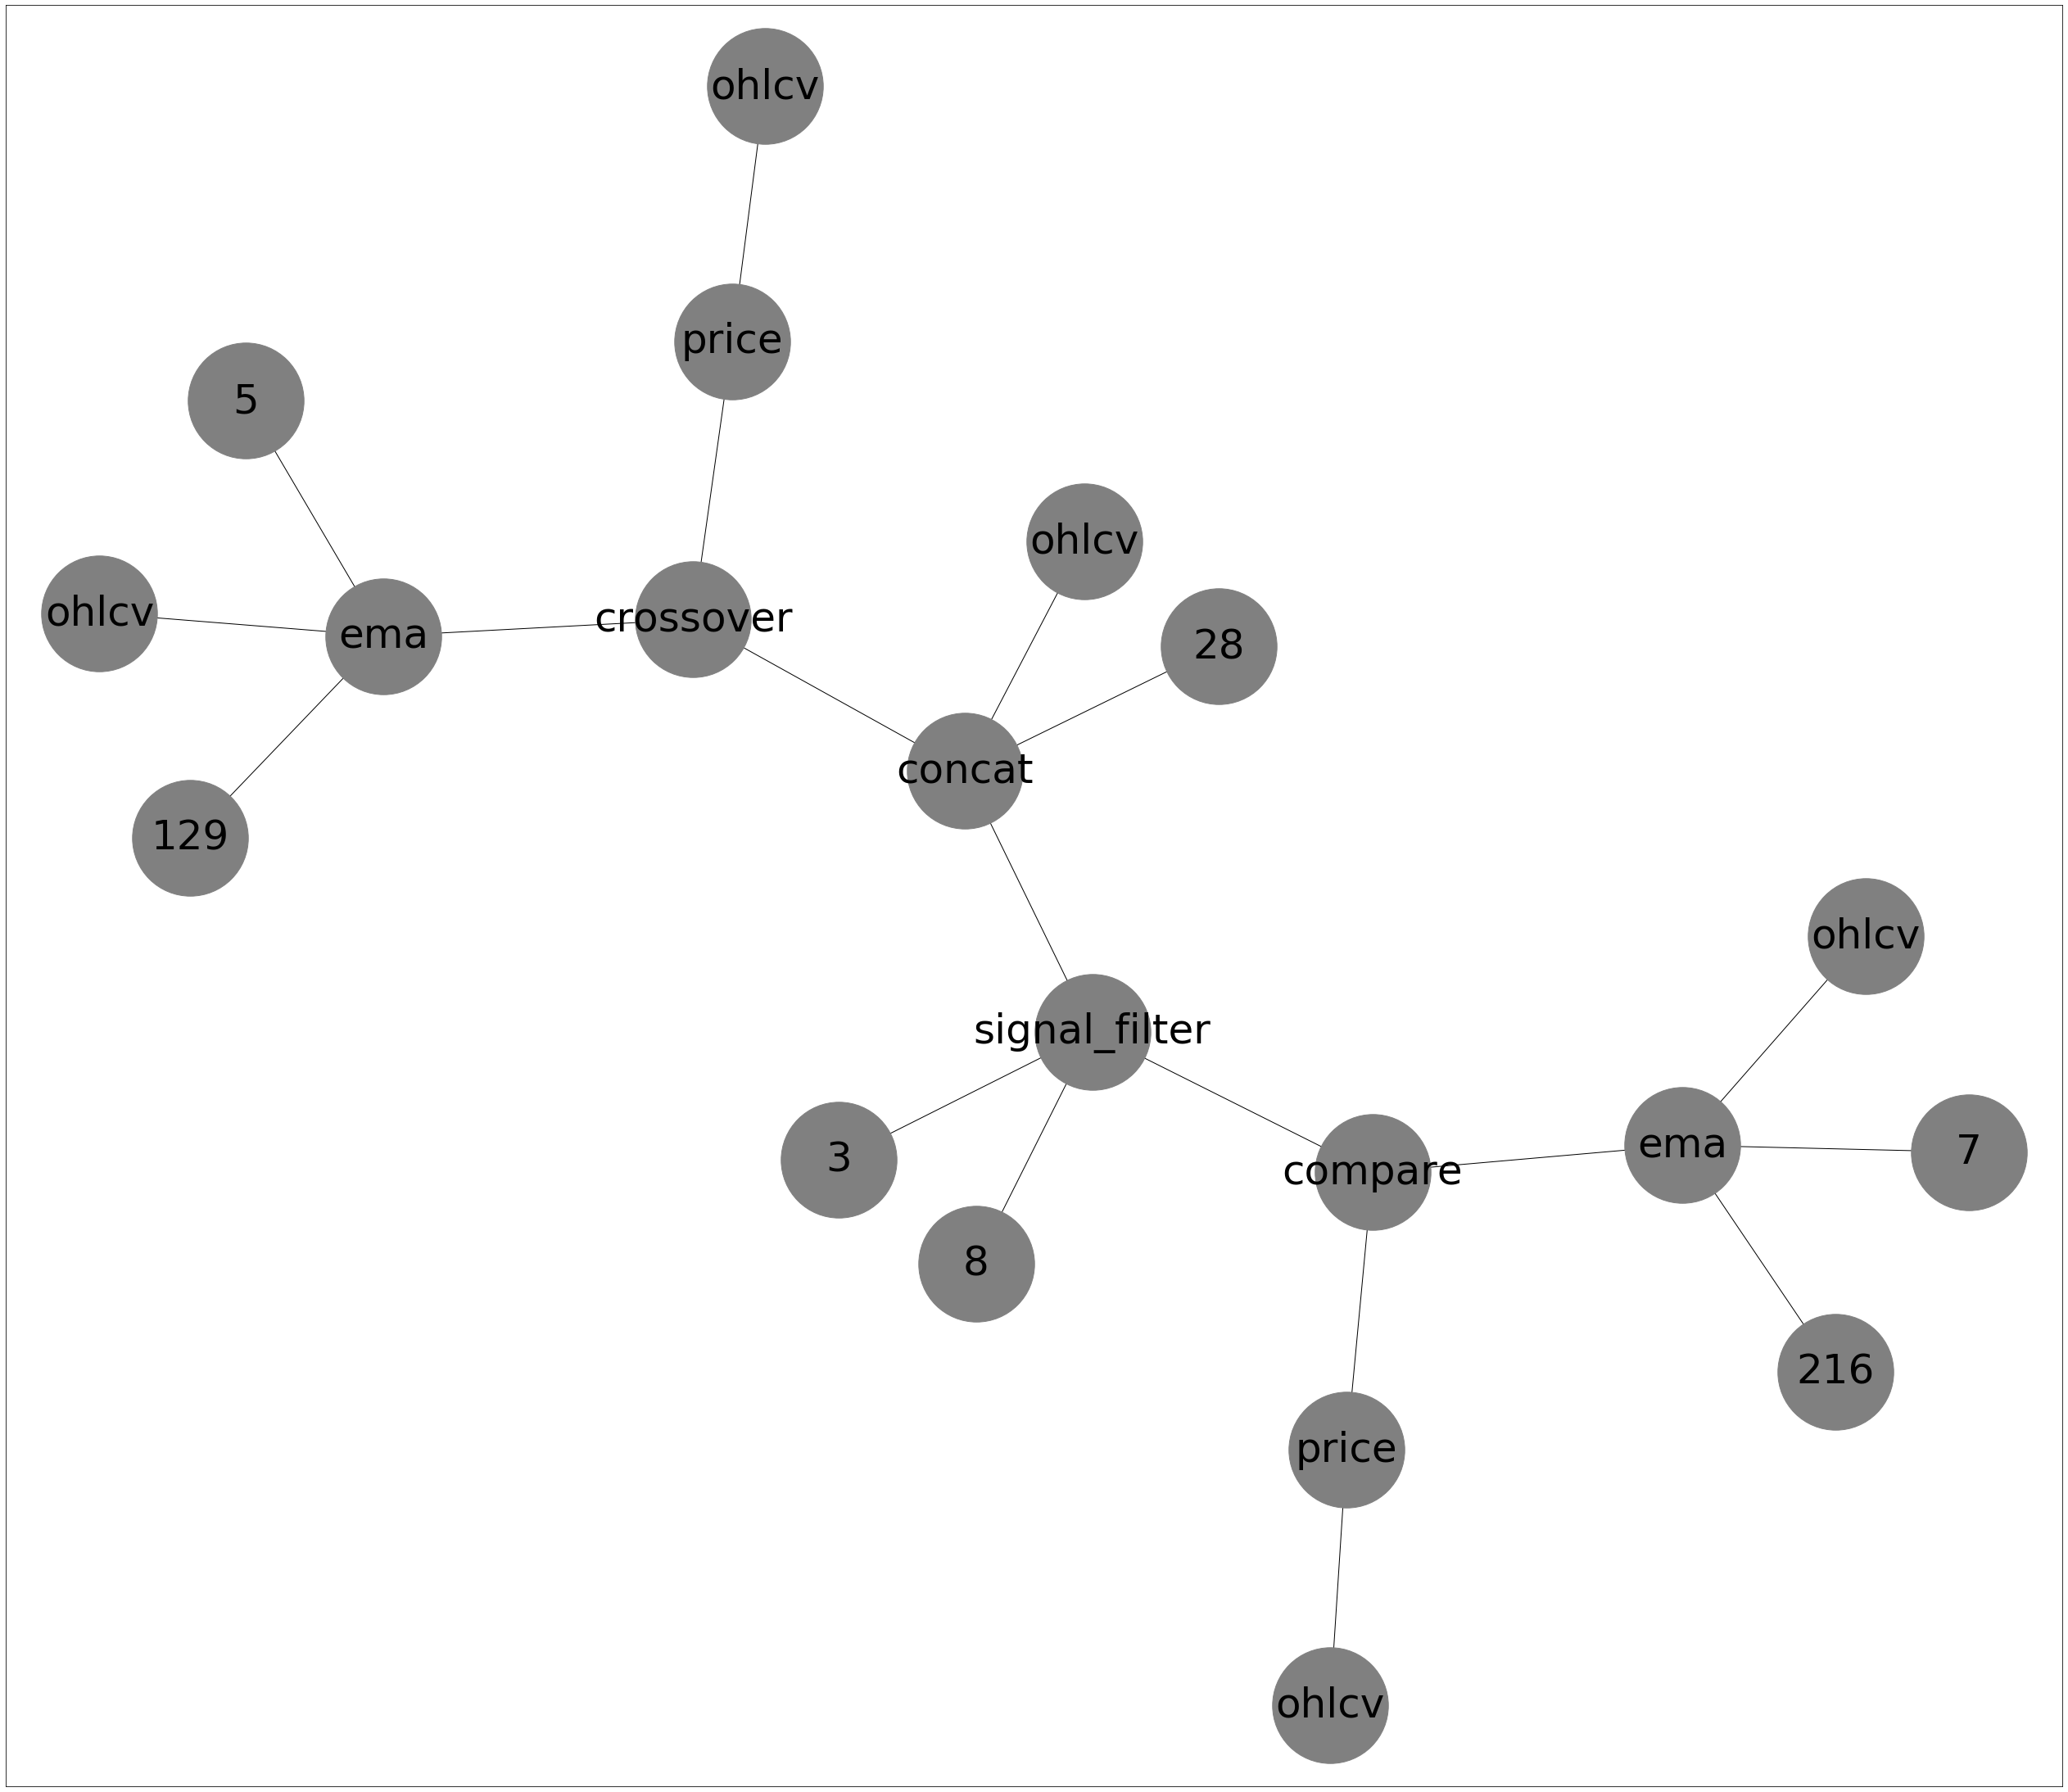

      entry     exit   type entry_time exit_time    profit closed
0   382.983  384.473  short         12        76  -3.02491   True
1   383.276  385.845   long         77       112   1.03076   True
2   385.794  384.803  short        115       143 -0.550194   True
3   384.947  393.818   long        144       317   7.31347   True
4   396.981  396.341  short        331       396 -0.946644   True
..      ...      ...    ...        ...       ...       ...    ...
64  937.682  921.288   long      11374     11737  -20.1119   True
65  921.215  921.279   long      11739     11779  -3.62099   True
66  920.755  923.139   long      11781     11837  -1.30379   True
67  923.926  923.523   long      11841     11869   -4.0979   True
68  923.175     None   long      11873      None      None  False

[69 rows x 7 columns]
4  	1    	80    	1 mins 15 secs	S   	-16000.1	2.64584 
5  	1    	85    	1 mins 5 secs 	S   	-17999.4	2.67328 


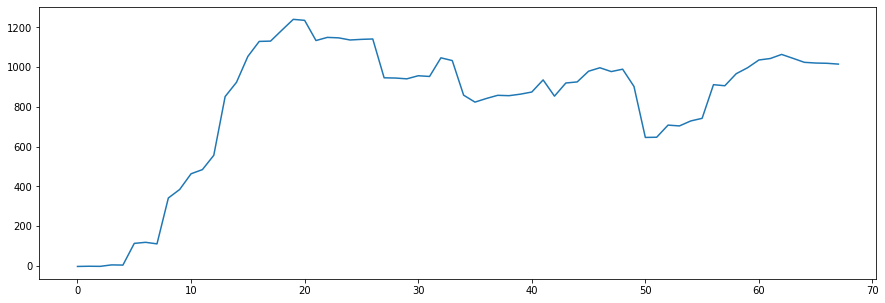

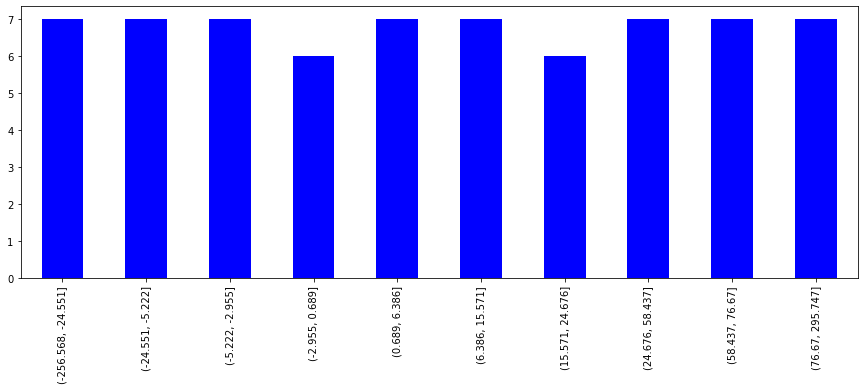

,Size,Execution Time,avg_ROI,Total Profit,Max Profit,Min Profit,Mean Profit,Root Number Trades,Standard Deviation,System Quality Number,Number Trades,Number Longs,Number Shorts,Number Positive,Sum Positive,Number Negative,Sum Negative,Number Not Closed,closed_ratio,mean_entry_time_diff,trade_duration,trade_time_coeff
0,26,0 mins 8 secs,0.012020,318.530656,299.089768,-180.861436,5.791466,12.238457,85.427628,0.829692,55,27,28,21,1712.641138,34,-1394.110482,1,0.982143,216.055556,215.672727,1.001775
1,26,0 mins 8 secs,0.031625,701.246134,285.846854,-97.751400,19.479059,9.390507,96.928652,1.887143,36,18,18,10,1559.952234,26,-858.706100,1,0.972973,340.142857,333.277778,1.020599
2,26,0 mins 8 secs,0.032343,1052.426882,359.037974,-191.294646,21.478100,11.386036,96.408483,2.536607,49,24,25,24,1942.343180,25,-889.916298,1,0.980000,243.145833,241.469388,1.006943
3,20,0 mins 6 secs,0.024238,1003.890328,295.746960,-256.566616,14.763093,13.973914,77.970759,2.645841,68,47,21,41,2068.144900,27,-1064.254572,1,0.985507,176.552239,166.558824,1.059999
4,20,0 mins 6 secs,0.024405,1015.534570,295.746960,-256.566616,14.934332,13.973914,78.065463,2.673283,68,47,21,41,2079.172912,27,-1063.638342,1,0.985507,176.552239,166.529412,1.060187


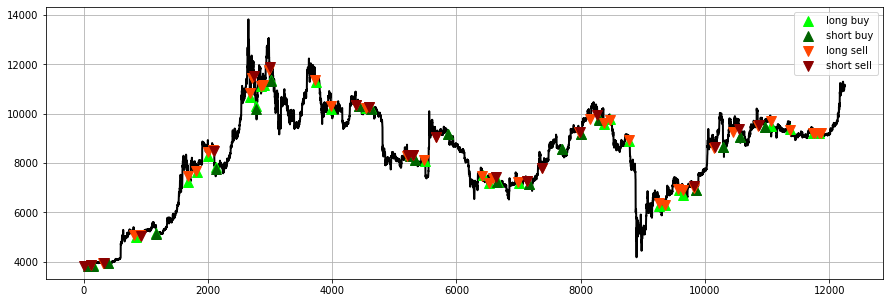

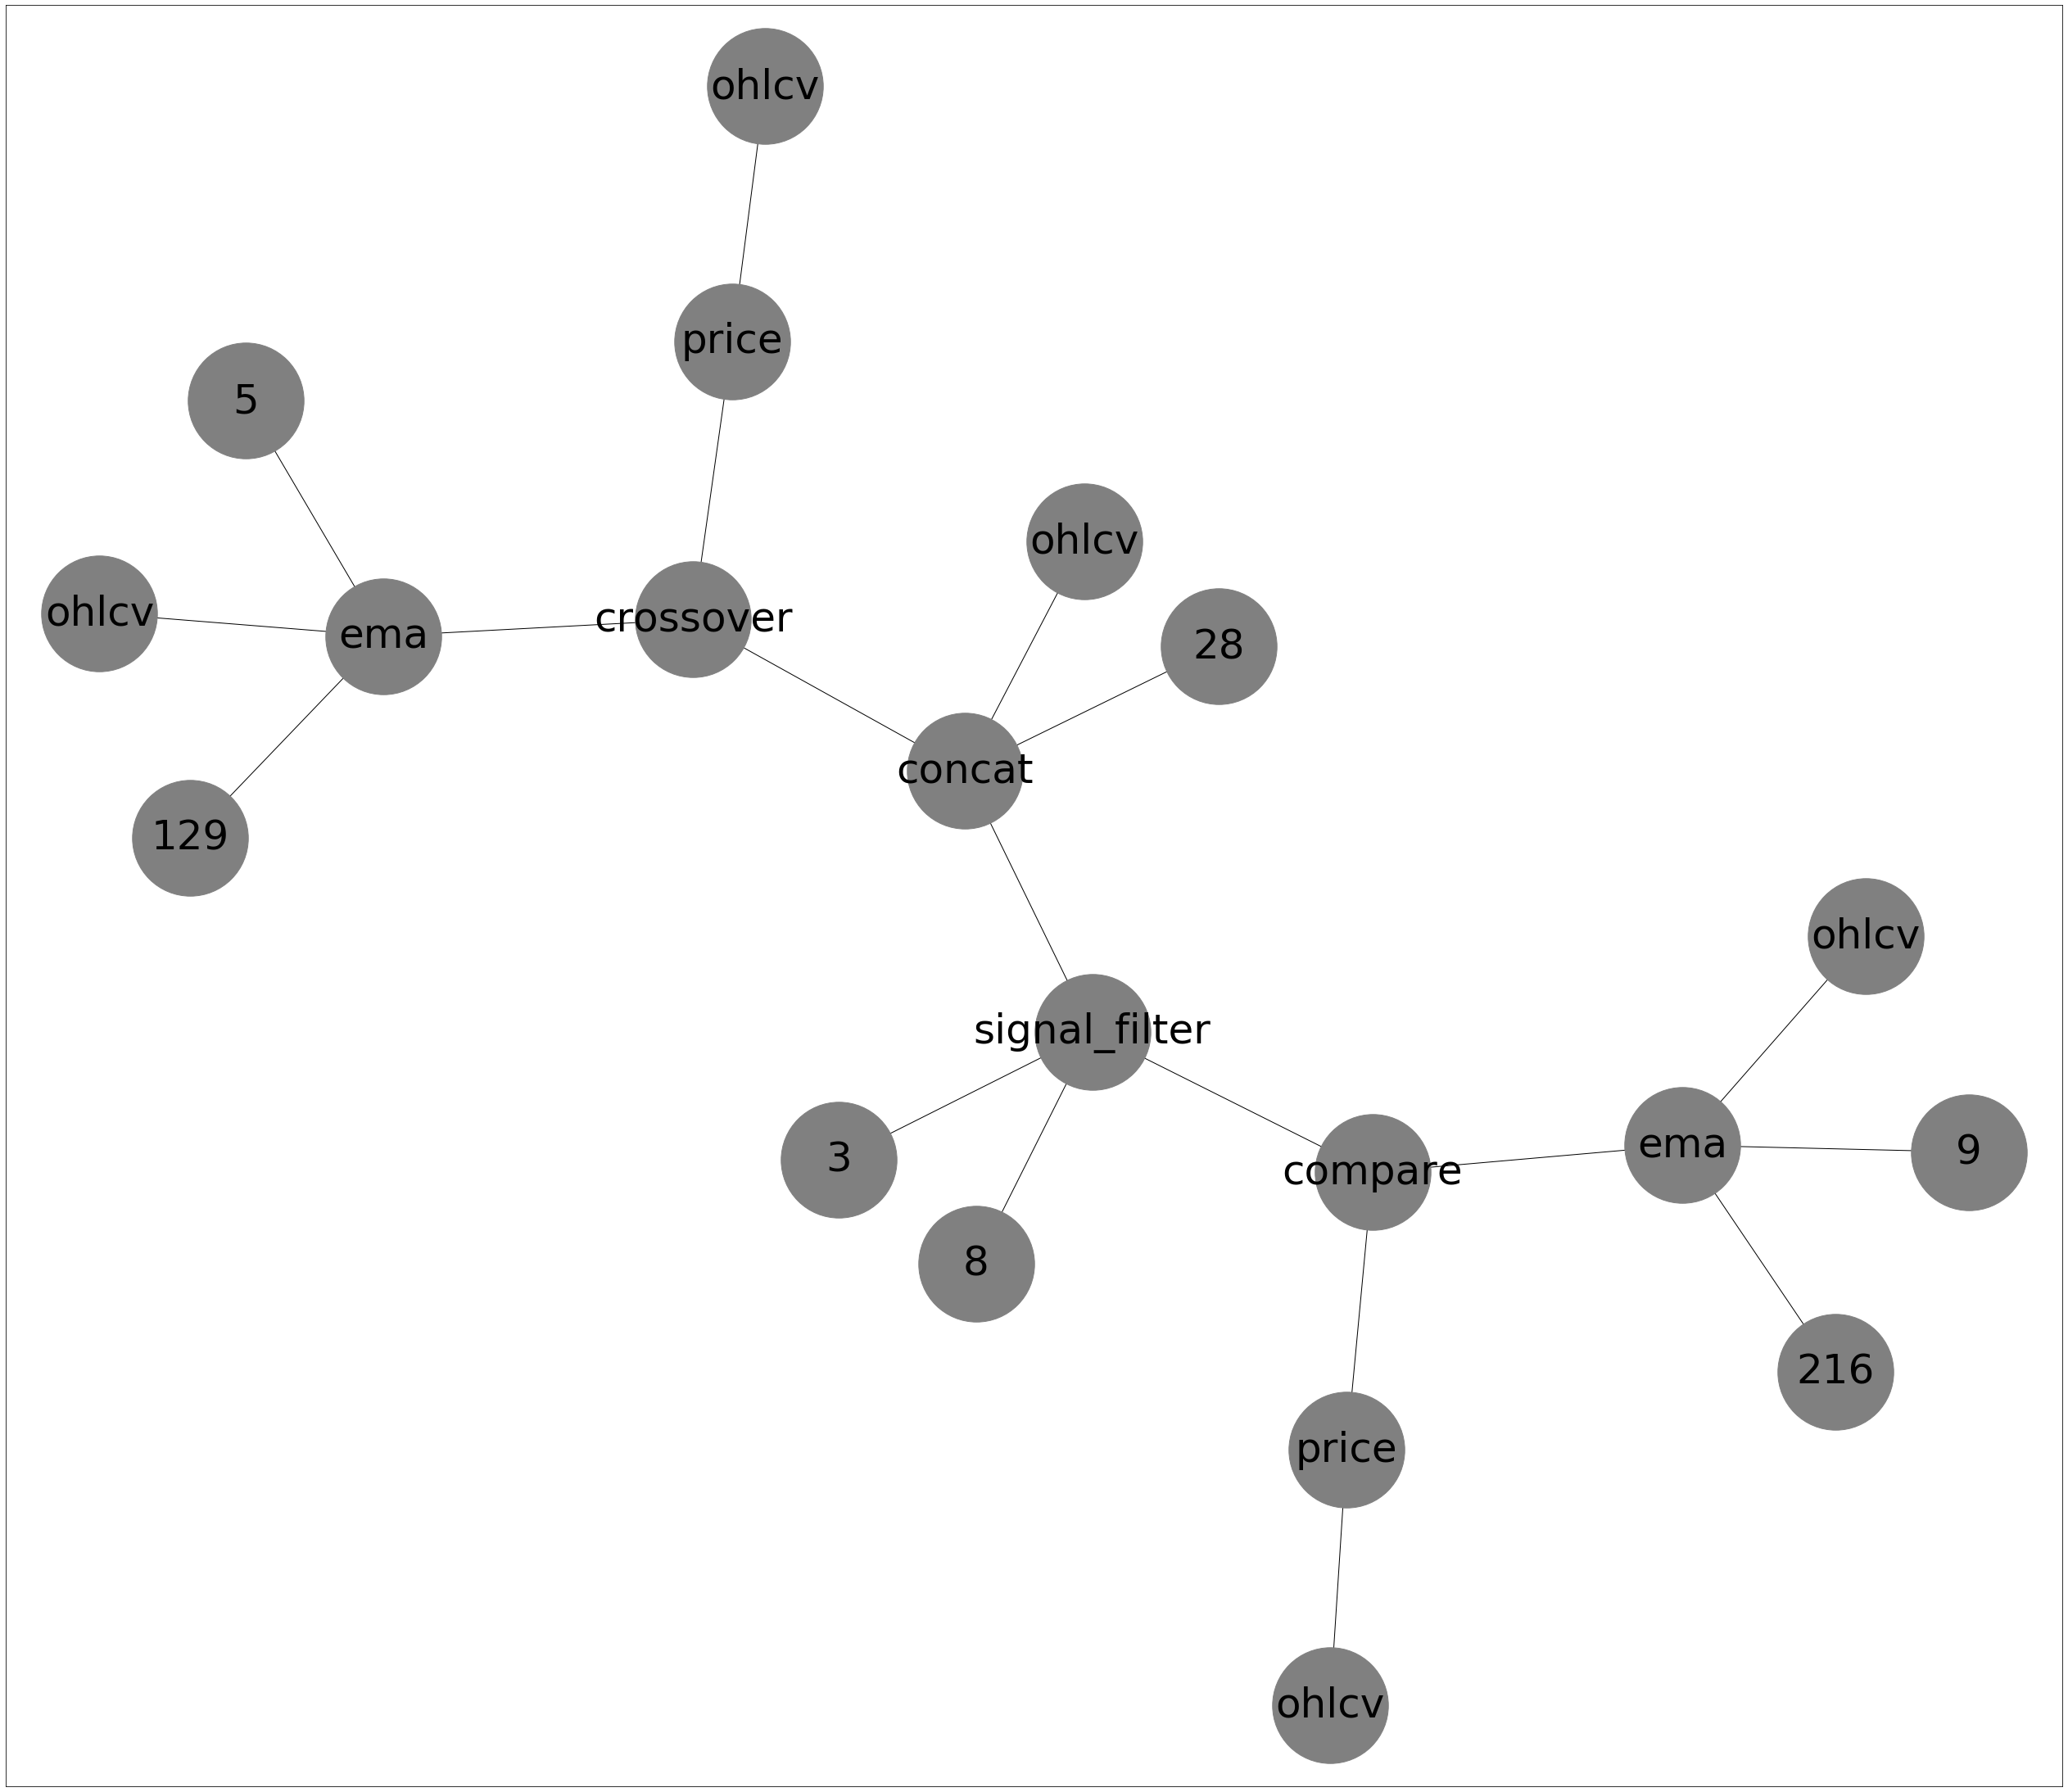

      entry     exit   type entry_time exit_time    profit closed
0   382.983  384.473  short         12        76  -3.02491   True
1   383.276  385.845   long         77       112   1.03076   True
2   385.794  384.803  short        115       143 -0.550194   True
3   384.947  393.818   long        144       317   7.31347   True
4   396.981  396.341  short        331       396 -0.946644   True
..      ...      ...    ...        ...       ...       ...    ...
64  937.682  921.288   long      11374     11737  -20.1119   True
65  921.215  921.279   long      11739     11779  -3.62099   True
66  920.755  923.139   long      11781     11837  -1.30379   True
67  923.926  923.523   long      11841     11869   -4.0979   True
68  923.175     None   long      11873      None      None  False

[69 rows x 7 columns]
6  	1    	80    	1 mins 26 secs	S   	-12999.6	2.67343 


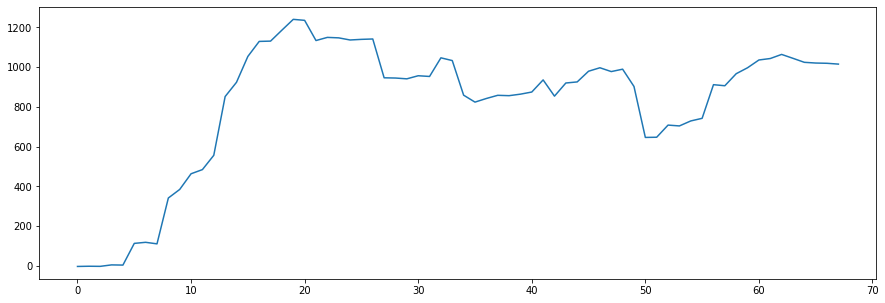

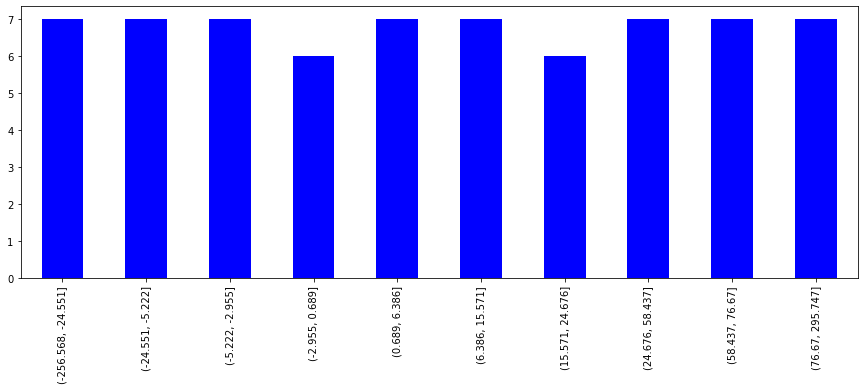

,Size,Execution Time,avg_ROI,Total Profit,Max Profit,Min Profit,Mean Profit,Root Number Trades,Standard Deviation,System Quality Number,Number Trades,Number Longs,Number Shorts,Number Positive,Sum Positive,Number Negative,Sum Negative,Number Not Closed,closed_ratio,mean_entry_time_diff,trade_duration,trade_time_coeff
0,26,0 mins 8 secs,0.012020,318.530656,299.089768,-180.861436,5.791466,12.238457,85.427628,0.829692,55,27,28,21,1712.641138,34,-1394.110482,1,0.982143,216.055556,215.672727,1.001775
1,26,0 mins 8 secs,0.031625,701.246134,285.846854,-97.751400,19.479059,9.390507,96.928652,1.887143,36,18,18,10,1559.952234,26,-858.706100,1,0.972973,340.142857,333.277778,1.020599
2,26,0 mins 8 secs,0.032343,1052.426882,359.037974,-191.294646,21.478100,11.386036,96.408483,2.536607,49,24,25,24,1942.343180,25,-889.916298,1,0.980000,243.145833,241.469388,1.006943
3,20,0 mins 6 secs,0.024238,1003.890328,295.746960,-256.566616,14.763093,13.973914,77.970759,2.645841,68,47,21,41,2068.144900,27,-1064.254572,1,0.985507,176.552239,166.558824,1.059999
4,20,0 mins 6 secs,0.024405,1015.534570,295.746960,-256.566616,14.934332,13.973914,78.065463,2.673283,68,47,21,41,2079.172912,27,-1063.638342,1,0.985507,176.552239,166.529412,1.060187
5,20,0 mins 6 secs,0.024407,1015.590682,295.746960,-256.566616,14.935157,13.973914,78.065361,2.673434,68,47,21,41,2079.229024,27,-1063.638342,1,0.985507,176.552239,166.500000,1.060374


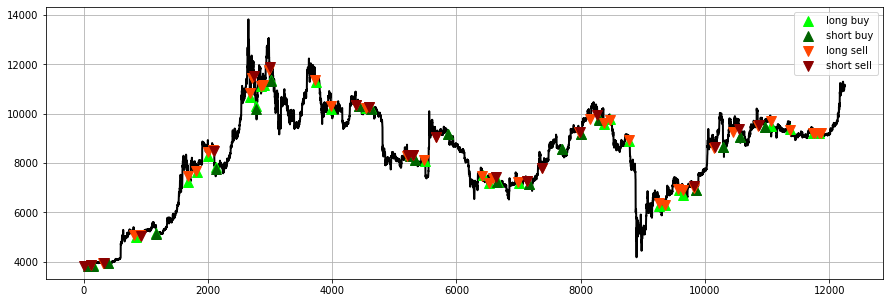

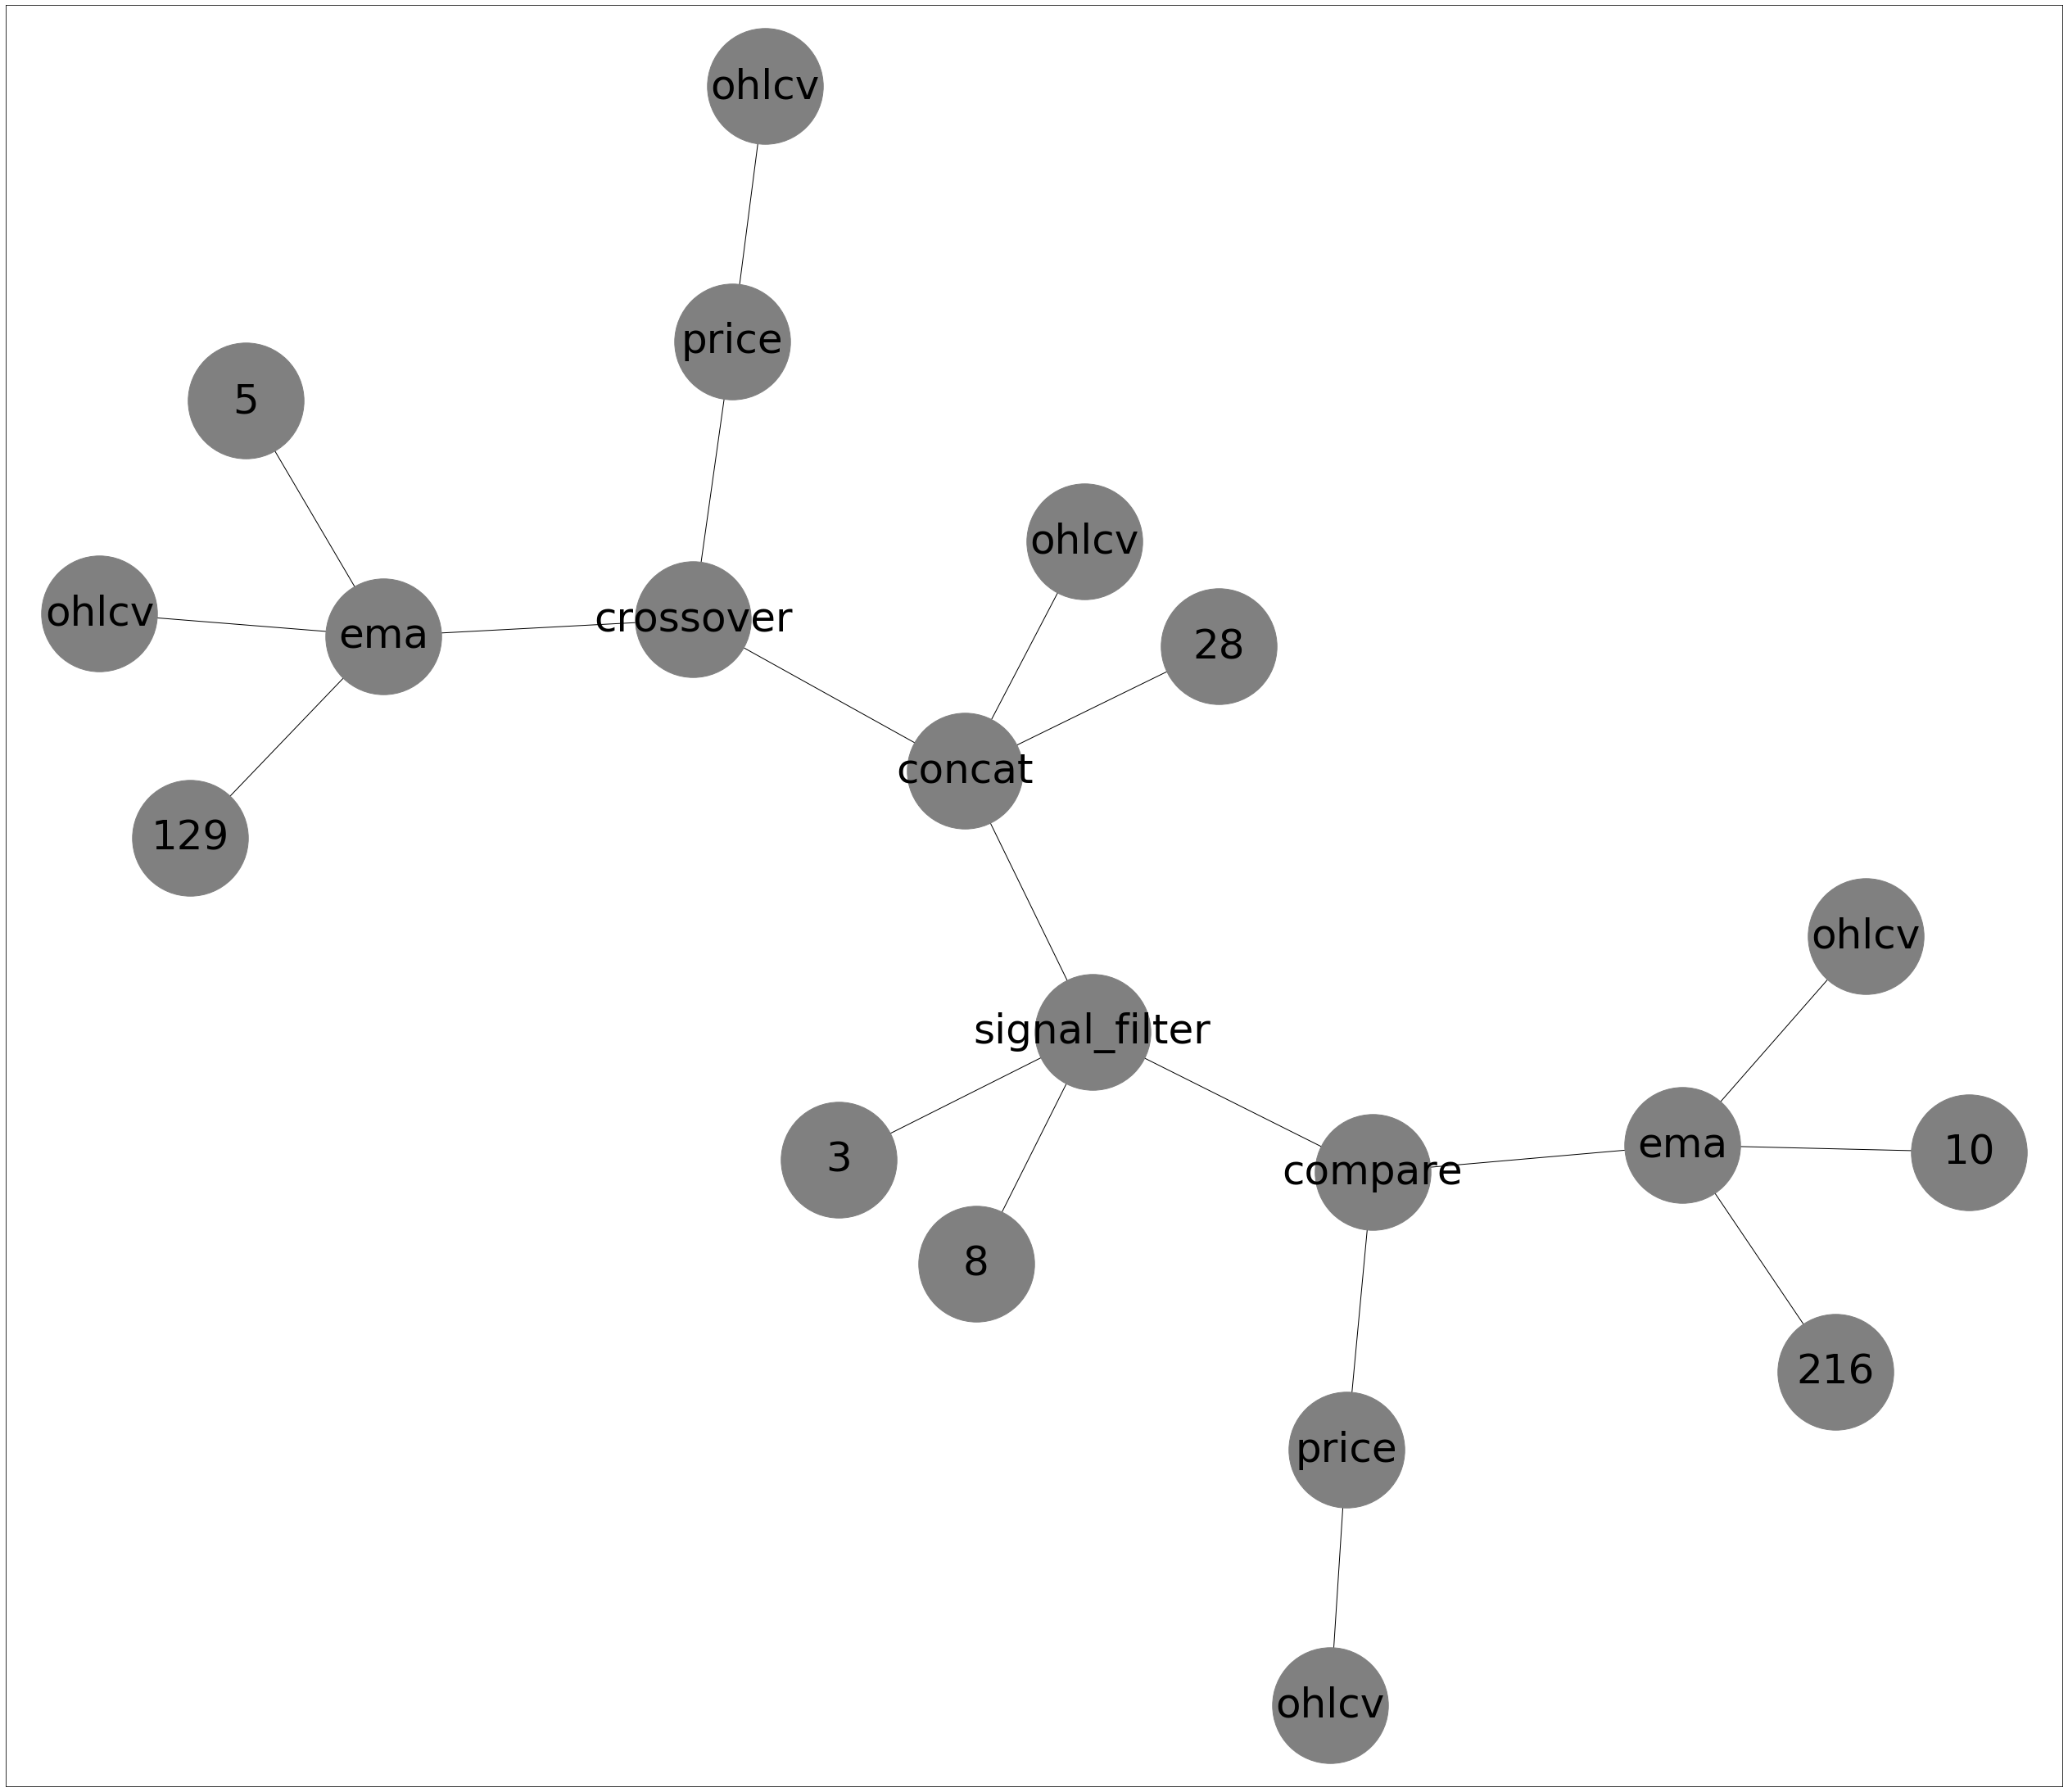

      entry     exit   type entry_time exit_time    profit closed
0   382.983  384.473  short         12        76  -3.02491   True
1   383.276  385.845   long         77       112   1.03076   True
2   385.794  384.803  short        115       143 -0.550194   True
3   384.947  393.818   long        144       317   7.31347   True
4   396.981  396.341  short        331       396 -0.946644   True
..      ...      ...    ...        ...       ...       ...    ...
64  937.682  921.288   long      11374     11737  -20.1119   True
65  921.215  921.279   long      11739     11779  -3.62099   True
66  920.755  923.139   long      11781     11837  -1.30379   True
67  923.926  923.523   long      11841     11869   -4.0979   True
68  923.175     None   long      11873      None      None  False

[69 rows x 7 columns]
7  	1    	89    	1 mins 30 secs	S   	-8998.92	2.67343 
8  	1    	88    	1 mins 28 secs	S   	-20998.7	2.67343 
9  	1    	83    	1 mins 17 secs	S   	-13999.6	2.67343 
10 	1    	88    	1 m

In [ ]:
demichad.evolve(100, 100)

In [ ]:
history = demichad.chad.history
history